# Preprocess data

In [1]:
# Load dataset
import pandas as pd
file_path = 'train_sortiert_new_format.csv'
df = pd.read_csv(file_path)
indices = df.index.tolist()
features = df.columns.tolist()
df.head()

,video_id,label_id,label,F1_L0_X,F1_L0_Y,F1_L0_Z,F1_L1_X,F1_L1_Y,F1_L1_Z,F1_L2_X,...,F37_L17_Z,F37_L18_X,F37_L18_Y,F37_L18_Z,F37_L19_X,F37_L19_Y,F37_L19_Z,F37_L20_X,F37_L20_Y,F37_L20_Z
0,1000,11,Sliding Two Fingers Left,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100011,20,Thumb Up,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10002,11,Sliding Two Fingers Left,0.269611,0.937481,4.710461e-07,0.302779,0.850025,-0.027882,0.300107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100031,12,Sliding Two Fingers Right,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,19,Thumb Down,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Set constants
n_frames = 37
n_landmarks = 21
n_dimensions = 3
n_samples = len(indices)
n_features = len(features)
print(f"{n_samples} samples with {n_features} features.")
print(f"video_id + label_id + label + {n_frames} Frames * {n_landmarks} Landmarks * {n_dimensions} Dimensions -> {3+n_frames*n_landmarks*n_dimensions}")

16318 samples with 2334 features.
video_id + label_id + label + 37 Frames * 21 Landmarks * 3 Dimensions -> 2334


In [3]:
# Convert coordinates to np.arr
import numpy as np
data = np.zeros((n_samples, n_frames, n_landmarks, n_dimensions), dtype=np.float16)
dim_dict = {0: "X", 1: "Y", 2: "Z"}

# Loop through all labels and store in data array
for f in range(1,n_frames+1):
    for l in range(n_landmarks):
        for d in range(n_dimensions):
            index = "F"+str(f)+"_L"+str(l)+"_"+dim_dict[d]
            data[:,f-1,l,d] = np.array(df[index])

print("The shape of the data is:      ", data.shape) # (n_samples, n_frames, n_landmarks, n_dimensions)
print("The percentage of 0 entries is:", np.round(np.sum(data<=0) / np.size(data)*100,3),"%")
print("The array has a size of:       ", np.round(data.nbytes/1024**2,2),"MB.")

The shape of the data is:       (16318, 37, 21, 3)
The percentage of 0 entries is: 76.41 %
The array has a size of:        72.55 MB.


In [4]:
# Generate train and test data
training_split = 0.9                                    # How much data for training and testing?

# random permutation of the indices
np.random.seed(42)                                      # Fix seed for reproducibility
indices = np.random.permutation(len(data))
split_index = int(len(data) * (1 - training_split))

# generate split index & split the data
train_indices = indices[split_index:]
test_indices = indices[:split_index]
labels = np.array(df["label_id"])
x_train, x_test = data[train_indices], data[test_indices]
y_train, y_test = labels[train_indices], labels[test_indices]
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(len(x_train)," samples for training.")
print(len(x_test)," samples for testing.")
print("Labels: ", np.unique(labels))

x_train shape: (14687, 37, 21, 3)
x_test shape: (1631, 37, 21, 3)
y_train shape: (14687,)
y_test shape: (1631,)
14687  samples for training.
1631  samples for testing.
Labels:  [ 5 10 11 12 13 19 20 24 26]


Stats:  1.284 -0.761 0.1055 0.0


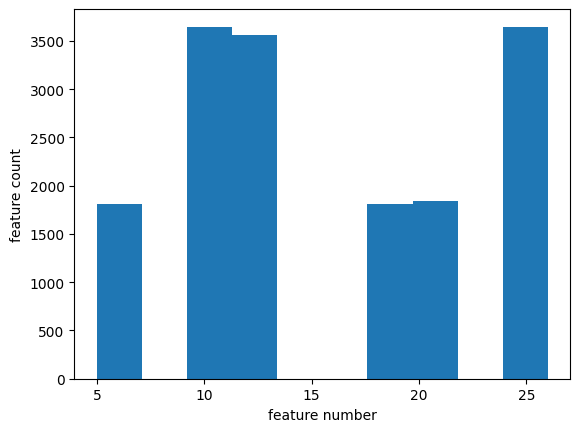

In [5]:
import matplotlib.pyplot as plt
print("Stats: ",np.max(x_train), np.min(x_train), np.mean(x_train), np.median(x_train))
plt.hist(labels)
plt.xlabel("feature number")
plt.ylabel("feature count")
plt.show()

In [6]:
def remove_sparse_samples(arr1, arr2, n): # removes samples that contain too many empty frames
    sparsity = np.sum(arr1==0, axis=1) / arr1.shape[1]
    ind = sparsity <= n
    return arr1[ind], arr2[ind]

# Single Frame

In [9]:
# Convert dataset to single frames
n = 0.2 # Max sparsity allowed
x_train_single = x_train.reshape(x_train.shape[0]*x_train.shape[1],-1)
x_test_single  = x_test.reshape(x_test.shape[0]*x_test.shape[1],-1)
y_train_single = np.repeat(y_train,37)
y_test_single = np.repeat(y_test,37)
print(x_train.shape, y_train_single.shape)
print(x_test.shape, y_test_single.shape, "\n")

# Remove sparse frames
x_train_single, y_train_single = remove_sparse_samples(x_train_single, y_train_single, n)
x_test_single, y_test_single = remove_sparse_samples(x_test_single, y_test_single, n)

print(x_train_single.shape, y_train_single.shape)
print(x_test_single.shape, y_test_single.shape)
print("Old sparsity: ",1-np.sum(x_train != 0)/x_train.size)
print("New sparsity: ",1-np.sum(x_train_single != 0)/x_train_single.size)

(14687, 37, 21, 3) (543419,)
(1631, 37, 21, 3) (60347,) 

(187955, 63) (187955,)
(20753, 63) (20753,)
Old sparsity:  0.6543723445064767
New sparsity:  0.0007148789836135538


# Multi frame

In [7]:
def return_multi_frame(train, label, n_frames, sparsity, flat=True):
    """
    Creates new samples with specified frames.
    For example if n_frames is one smaller than the original n_frames, then you will get double the samples.
    """
    
    print("old train: ",train.shape)
    print("old label: ",label.shape)
    # 1. Step Convolve and create new samples
    new_train = np.zeros((train.shape[0], train.shape[1]-n_frames+1, n_frames, train.shape[2], train.shape[3]))
    new_label = np.zeros((label.shape[0], train.shape[1]-n_frames+1))

    for j, sample in enumerate(train):
        for i in range(train.shape[1]-n_frames+1):
            new_sample = sample[i:i+n_frames,:,:]
            new_train[j,i,:,:,:] = new_sample
            new_label[j,i] = label[j]

    # 2. Step Filter samples with high sparsity
    new_train = new_train.reshape(new_train.shape[0]*new_train.shape[1], -1)   # First flatten to remove sparse samples
    new_label = new_label.reshape(new_label.shape[0]*new_label.shape[1])
    new_train, new_label = remove_sparse_samples(new_train, new_label, sparsity) # remove sparse samples

    if not flat:  # Reshape if you dont want to get the flat array
        new_train = new_train.reshape(-1,n_frames,train.shape[2],train.shape[3])
        new_label = new_label.reshape(-1)
    print("new_train: ",new_train.shape)
    print("new_label: ",new_label.shape)
    return new_train, new_label

In [8]:
n_frames = 10
x_train_multi, y_train_multi = return_multi_frame(x_train, y_train, n_frames, 0.2, flat=True)
x_test_multi, y_test_multi = return_multi_frame(x_test, y_test, n_frames, 0.2, flat=False)
# samples, n_frames (10) * n_landmarks (21) * dim (3) or samples, n_frames (10), n_landmarks (21), dim (3) depending if you choose flat=True or False

old train:  (14687, 37, 21, 3)
old label:  (14687,)
new_train:  (104090, 630)
new_label:  (104090,)
old train:  (1631, 37, 21, 3)
old label:  (1631,)
new_train:  (11185, 10, 21, 3)
new_label:  (11185,)
